In [1]:
import numpy as np
import numpy.matlib
import pandas as pd
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

#get_ipython().run_line_magic('matplotlib', 'inline')
from mne.filter import filter_data
from scipy.signal import find_peaks_cwt, welch, find_peaks, hilbert, periodogram
from scipy import integrate
from scipy.stats import spearmanr
#from entropy import shannon_entropy, sample_entropy
import time
from os import listdir
from os.path import isfile, join

import pyedflib
from datetime import timedelta
from scipy.signal import decimate
import time
from os import listdir
from os.path import isfile, join

import os
path="/Users/jeroenhabets/Desktop/python_code/bradykinesia analysis"
os.chdir(path)

In [2]:
### variables for sensor + EMA analysis
windowLen = 60 # windowLength = frame (in seconds) of sensor data over which one feature is calculated
sampleRate = 100 # freq on which sensor data is extracted

In [3]:
def extractFeatures(data, esm,sr, windowLength=windowLen):

    numSamples=data.shape[0]
    # Getting number and names of features
    print(data[0,:windowLength*sr,:].shape)

    tremorNames = []
    tremorNames, _ = tremorFeatures(data[0,:windowLength*sr,:], sr,windowLength=windowLength)
    bradyNames, _ = bradykinesiaFeatures(data[0,:windowLength*sr,:], sr,windowLength=windowLength)
#    bradyNames, _ = TestBradykinesiaFeatures(data[0,:windowLength*sr,:], sr,windowLength=windowLength) # TEST!!!
    cols=[]
    for s in ['L','R','C']:
        cols.extend([c + s for c in tremorNames])
        cols.extend([c + s for c in bradyNames])
    cols.extend(esm.keys())
    aligned = pd.DataFrame(columns=cols)
    accelerometerChannel = [a + b for a in  [0,6,12] for b in range(3)] 
    ## where is gyrochannel -> gyroscope s have mean 0 already in not moving position; acc's have gravitational
    # acceleration. subtracting mean brings mean of acc's also to zero for readability.
    
    for beep in range(data.shape[0]):
        t=time.time()
        allFeat = []
        numWindows = int(data.shape[1]/sr/windowLength)
        buff = data[beep,:,:]
        buff[:,accelerometerChannel] = (buff[:,accelerometerChannel].T - np.mean(buff[:,accelerometerChannel].T,axis=0)).T
        for s,sID in enumerate([range(6),range(6,12),range(12,18)]):
            
            features=np.zeros((numWindows,len(tremorNames)+len(bradyNames))) #
            for i in range(0,numWindows):
                win = i * windowLength * sr
                _, features[i,:len(tremorNames)] = tremorFeatures(buff[win:win+windowLength*sr,sID],sr,windowLength=windowLength)
                a = bradykinesiaFeatures(buff[win:win+windowLength*sr,sID],sr,windowLength=windowLength)
                _, features[i,len(tremorNames):] = bradykinesiaFeatures(buff[win:win+windowLength*sr,sID],sr,windowLength=windowLength)
#                 a = TestBradykinesiaFeatures(buff[win:win+windowLength*sr,sID],sr,windowLength=windowLength) ## TEST
#                 _, features[i,len(tremorNames):] = TestBradykinesiaFeatures(buff[win:win+windowLength*sr,sID],sr,windowLength=windowLength) # TEST


            allFeat.append(features)
        allFeat = np.concatenate(allFeat,axis=1)
        allFeat = np.concatenate((allFeat, np.matlib.repmat(esm.iloc[beep,:],numWindows,1)),axis=1)
        aligned = aligned.append(pd.DataFrame(allFeat,columns = cols),ignore_index=True)
        
    return aligned







In [4]:
def tremorFeatures(windowData,sr,windowLength=windowLen):
    tremorChannel={'AccX':0,'AccY':1,'AccZ':2,'gyrX':3,'gyrY':4,'gyrZ':5} # gyro is xyz 3-4-5  ## !! IS ACCXYZ 012 OR 123?? it was 123 in script
    if windowData.shape[0]!=sr*windowLength:
        print(windowData.shape,sr*windowLength)
    #freq = np.fft.rfftfreq(windowLength*sr, d=1./sr)
    #selected=np.logical_and(freq>3.5,freq<8)
    features=[]
    featureNames=[]
    for ch in tremorChannel.keys():
        #spec = np.mean(np.log(np.abs(np.fft.rfft(windowData[:,tremorChannel[ch]]))[selected]))
        f, spec = welch(windowData[:,tremorChannel[ch]], fs=sr, nperseg=sr )
        selected = np.logical_and(f>3.5,f<8)
        spec = np.mean(np.log(spec[selected])) # np.log
        features.append(spec)
        featureNames.append('tremorBandPower' + ch)
        
        
    return featureNames, features



In [5]:
## accelerometer featres to extract

# - mean segment velocity; overall and while moving (square root of sum of squares of signal derivatives)
# - intensity; root mean square
# - % of time moving (>0.05 m/sec)
# - activity (> 0.1 g -> 0.98 m/s)
# - mean duration of immobility periods
# - Power-law exponents (temporal autocorrelation) for local maxima and minima of fluctuations in activity time series
# - mean acceleration/velocity
# - dom. frequency



In [6]:
### test; extract Stroke features? 
# https://www.ncbi.nlm.nih.gov/pubmed/29843413 

## perform PCA for dominant feature axis? (Shah 2018 EMBC tremor detection in stn lfp)
# time frequency faetures; Hjorth parameters; B. Hjorth, “EEG analysis based on time domain properties,”
# Electroencephalogr. Clin. Neurophysiol., vol. 29, no. 3, pp. 306–
# 310, 1970.


In [7]:
from sampen import sampen2
from scipy.special import entr


In [8]:
def ApEn(U, m, r):
# https://en.wikipedia.org/wiki/Approximate_entropy
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)

    return abs(_phi(m+1) - _phi(m))

In [9]:

# sampen2 doc: https://sampen.readthedocs.io/en/stable/
# https://www.machinelearningplus.com/time-series/time-series-analysis-python/


In [10]:
def TestBradykinesiaFeatures(windowData,sr,windowLength=windowLen):
    features=[]
    featureNames=[]
    accelerometerChannel={'AccX':0,'AccY':1,'AccZ':2} 
    gyroChannel = {'GyrX':3,'GyrY':4,'GyrZ':5}
    # bandpass filtering acc and gyro (0.5 - 3.5 Hz) channels between 0.5 and 3.5,windowData stays dataframe with all 6 channels
    # high pass filter of 0.5 Hz immediately removes bias drift (Salarian, highpass 0.25 Hz)   
    
    windowData[:,list(accelerometerChannel.values())] = filter_data(windowData[:,list(accelerometerChannel.values())].T,sr,0.5,3.5,method='iir',verbose='WARNING').T
    windowData[:,list(gyroChannel.values())] = filter_data(windowData[:,list(gyroChannel.values())].T,sr,0.5,3.5,method='iir',verbose='WARNING').T
# salarian 2007: 8-degree IIR low-pass filter 3.5 Hz; similar??

    freq = np.fft.rfftfreq(windowLength*sr, d=1./sr)
    sel = np.logical_and(freq>=0.2,freq <= 4)
# accelerometer bradykinesia features
    
    for ch in accelerometerChannel.keys():
        ## from Griffiths '12
        # peak acc, per 2 minutes epoch
        # ?? take absolute windowdata to search for peaks?
        peakind,_ = find_peaks(windowData[:,accelerometerChannel[ch]], distance = 12000 ) # peak per 2 minutes; 100 Hz, 120 seconds: 200 samples 
        # peakind is array of peakindices
        
        peakMSPs = []
        for p in peakind:
            msp = np.mean((windowData[:,accelerometerChannel[ch]][p-1000:p+1000]**2)) # mean power over interval 10 sec's before and after peak
            peakMSPs.append(msp) # array of mean spectral powers around peaks
        
        grifPeaks = np.mean(peakMSPs) * len(peakind) # results in 1 float per window; score for mean MSPs and number of peaks
        features.append(grifPeaks)
        featureNames.append('grifPeaks' + ch)

        ##time of no movement wihtin 120 sec epochs, from Griffiths '12 -> covered by different %Movement feature

#         # Entropy from Cancela '10/ Tzallas/Pastorino
#         # Rms, sample entropy, approximate entropy, Range of values and cross correlation
#         accEntr = entr(windowData[:,accelerometerChannel[ch]]).sum(axis=0)/np.log(2) # /axis 0 to calculate entropy for one column (axis=1 calculates one row)
#         # /log(2): https://stackoverflow.com/questions/33607071/fastest-way-to-compute-entropy-of-each-numpy-array-row 
#         features.append(accEntr)
#         featureNames.append('accEntrop' + ch)
#         ## !! EXTREME SLOW
        
#         # approximate entropy (see field ApEn), std m=2, r=3
#         accApEn = ApEn(windowData[:,accelerometerChannel[ch]],2,3)
#         features.append(accApEn)
#         featureNames.append('accApEn' + ch)
#         ## !! EXTREME SLOW
        
#         #ent = shannon_entropy(windowData[:,accelerometerChannel[ch]])
#         #features.append(ent)
#         #featureNames.append('Entropy' + ch)

#         domEnergyRatio = np.max(spec) / np.sum(spec)
#         features.append(domEnergyRatio)
#         featureNames.append('DomEnergyRatio' + ch)

# power-law exponents for local maxima and minima (temporal autocorrelation) Pan '07


        
        ## Klapper '03: absolute derivative of acc magnitude
    
    # Tehuva (review): Griffiths: stride freq, acc and amplitude??
        # cross-correlation values from Cancela '10/ Tzallas/Pastorino
#     cCMax=[]
#     cCLocs=[]
#     for i, ch1 in enumerate(accelerometerChannel.keys()):
#         for j,ch2 in enumerate(list(accelerometerChannel.keys())[i+1:]):
#             crossCorr = np.correlate(windowData[:,accelerometerChannel[ch1]],windowData[:,accelerometerChannel[ch2]],'same')
#             crossCorr = crossCorr/(np.std(windowData[:,accelerometerChannel[ch1]]) * np.std(windowData[:,accelerometerChannel[ch2]]))
            
#             cCMax.append(np.max(crossCorr))
#             cCLocs.append(np.argmax(crossCorr))
#     features.append(np.max(cCMax))
#     featureNames.append('MaxCC')
#     features.append(cCLocs[np.argmax(cCMax)])
#     featureNames.append('MaxCCLoc')


## PM: read pipeline on LSTM RNN's by McDaniel and Quinn (pdf)
## PM: check method from EMBC, French name statistics for sensors


    for ch in gyroChannel.keys():
        sig = windowData[:,gyroChannel[ch]]
        
        # % time moving (of total window?), number of window moving within widndow length?
        
    ## Di Biasi 2018 (peak value, total power, fatigability, smoothnes; and freq-domain features)
        # peak value
        
        # total power
        
        # fatigability
        
        # smoothness
        
    #features.append(np.max(windowData[0:3,:]))
    #featureNames.append('MaxMovement')
    return featureNames, features


In [11]:
# In[145]:


def bradykinesiaFeatures(windowData,sr,windowLength=windowLen):
    features=[]
    featureNames=[]
    accelerometerChannel={'AccX':0,'AccY':1,'AccZ':2} 
    gyroChannel = {'GyrX':3,'GyrY':4,'GyrZ':5}
    # bandpass filtering acc and gyro (0.5 - 3.5 Hz) channels between 0.5 and 3.5,windowData stays dataframe with all 6 channels
    # high pass filter of 0.5 Hz immediately removes bias drift (Salarian, highpass 0.25 Hz)   
    
    windowData[:,list(accelerometerChannel.values())] = filter_data(windowData[:,list(accelerometerChannel.values())].T,sr,0.5,3.5,method='iir',verbose='WARNING').T
    windowData[:,list(gyroChannel.values())] = filter_data(windowData[:,list(gyroChannel.values())].T,sr,0.5,3.5,method='iir',verbose='WARNING').T
# salarian 2007: 8-degree IIR low-pass filter 3.5 Hz; similar??

    freq = np.fft.rfftfreq(windowLength*sr, d=1./sr)
    sel = np.logical_and(freq>=0.2,freq <= 4)
# accelerometer bradykinesia features
    
    for ch in accelerometerChannel.keys():
        
        # dominant frequency
        spec = np.abs(np.fft.rfft(windowData[:,accelerometerChannel[ch]]))
        domFreq = freq[np.argmax(spec)]
        features.append(domFreq)
        featureNames.append('DomFreq' + ch)
        
        # MSP between 0.2 and 4 Hz per 2 min? from Griffiths '12
        # mean spectral power within 0.2-4.0 Hz
        features.append(np.mean(spec[sel]))
        featureNames.append('powerSpec' + ch)
        
        
        # RMS from Cancela '10
        rms = np.sqrt(np.mean(windowData[:,accelerometerChannel[ch]]**2))
        features.append(rms)
        featureNames.append('RMS' + ch)
        
        
        # range of values (amplitudes) from Cancela '10
        ampRange = np.max(windowData[:,accelerometerChannel[ch]]) - np.min(windowData[:,accelerometerChannel[ch]])
        features.append(ampRange)
        featureNames.append('AmpRange' + ch)


        #peak acc, per 2 minutes, from Griffiths '12
        peakind,_ = find_peaks(windowData[:,accelerometerChannel[ch]], distance = 1200 ) #distance =  2 min epoch -> 1200 samples 
        ## peaks can now be pos and neg? take peak of absolute raw data??
        accPeak = np.mean(windowData[:,accelerometerChannel[ch]][peakind]) # results in 1 float
        ## ?? this gives mean over peaks in 15 min's... better max peak? see new Griffiths feature in Test
        features.append(accPeak)
        featureNames.append('accPeak' + ch)

        ## acc-features checked till HERE
    
        ## from Griffiths '12
        # peak acc, per 2 minutes epoch
        # ?? take absolute windowdata to search for peaks?
        # peakind is array of peakindices
        
        peakMSPs = []
        for p in peakind:
            msp = np.mean((windowData[:,accelerometerChannel[ch]][p-1000:p+1000]**2)) # mean power over interval 10 sec's before and after peak
            peakMSPs.append(msp) # array of mean spectral powers around peaks
        
        grifPeaks = np.mean(peakMSPs) * len(peakind) # results in 1 float per window; score for mean MSPs and number of peaks
        features.append(grifPeaks)
        featureNames.append('grifPeaks' + ch)
    
    # gechecked t/m segvolmovacc
    # Dunnewold '98
    # abs(vectorial sum of acc's), in 1/32 sec? PM: 3-axis transalation of original 2-axis acc feature
    absVecSum = np.abs(windowData[:,0])+np.abs(windowData[:,1])+np.abs(windowData[:,2])
    features.append(np.mean(absVecSum))
    featureNames.append('meanAbsVecSum')
    
    # period without exceeding threshold -> like Keijsers, segMov??
    absVecImmob = absVecSum < 0.1 # gives Boolean array with True for absVecSum < x

    percAbsVecImmob = absVecImmob.sum()/len(absVecImmob)
    features.append(percAbsVecImmob)
    featureNames.append('%AbsVecImmob') # not real percentage but from 0 til 1
    
    #Keijsers, segment velocity, seg vel while moving, % moving
     # mean segment velocity (Keijsers) -> pg4!!; per 60sec intervals
        # velocity: sqrt of sum of squares of sign derivatives
    derivative = np.zeros((windowData.shape[0],3))
    derivative[:,0] = np.append(np.diff(windowData[:,0]),0) # append bcs diff has length - 1
    derivative[:,1] = np.append(np.diff(windowData[:,1]),0)
    derivative[:,2] = np.append(np.diff(windowData[:,2]),0)

    segVel = np.sqrt(derivative[:,0]**2+derivative[:,1]**2+derivative[:,2]**2)
    meanSegVel = np.mean(segVel)
    features.append(meanSegVel)
    featureNames.append('meanSegVel')
    
    meanSegVelMov = []
    if segVel.any() > 0.05:
        meanSegVelMov = np.append(meanSegVelMov, np.mean(segVel))
    else:
        meanSegVelMov = np.append(meanSegVelMov, 0)
    features.append(np.mean(meanSegVelMov)) # or np.mean remove
    featureNames.append('meanSegVelMov')
    
    segMov = segVel>0.05
    percMovAcc = segMov.sum()/len(segMov)
    features.append(percMovAcc)
    featureNames.append('%SegVolMovAcc') # not real percentage
    

    
    
    
    
    # gyroscope bradykinesia features !!!!!!!!
 
    for ch in gyroChannel.keys():
        sig = windowData[:,gyroChannel[ch]]

        # average angular velocity; as well as angular speed (Costa 15), only Y-axis?
        angvel = np.mean(np.abs(windowData[:,gyroChannel[ch]]))
        features.append(angvel)
        featureNames.append('angularVelocity' + ch)
        
        # RMS of angular velocity (Salarian 07)
        rms = np.sqrt(np.mean(windowData[:,gyroChannel[ch]]**2))
        features.append(rms)
        featureNames.append('angularRMS' + ch)
        # calculate average rms over 5 or 15 minutes? (now rms per windowlength (60 s))
        
              
        # signal descriptor from quantitative kinematic measures (diff. effect DBS settings) (Costa 2015)
        
        peakind,_ = find_peaks(sig,) #widths = add 0.2/sec width interval? 
        avepeak = np.mean(sig[peakind])
        phiCosta = np.sqrt(angvel * np.mean(avepeak))
        features.append(phiCosta)
        featureNames.append('phiCosta' + ch)
        
        
        # periods of movement (Salarian 07)
        gyrSig = windowData[:,gyroChannel[ch]]
        hilSig = hilbert(gyrSig)
        instanAmpl = np.abs(gyrSig + hilSig)
        partMov = np.count_nonzero(instanAmpl > 5) / len(instanAmpl)
        features.append(partMov)
        featureNames.append('partMoveHil' + ch)
        
        # average range of rotation (integration signal) (Salarian 07)
        intSig = integrate.simps(windowData[:,gyroChannel[ch]])
        features.append(intSig)
        featureNames.append('rangeRotation' + ch)
        
       
    # magnitude, free after Pulliam (without multiply with ankle sensor)   
    # over windowlength: absolute mean -> squared; sum of squared x,y,z -> squareroot
    # with OR without np.abs per axis
    gyrMagn = np.sqrt(np.mean(np.abs(windowData[:,3]))**2+ np.mean(np.abs(windowData[:,4]))**2+np.mean(np.abs(windowData[:,3]))**2) 
    features.append(gyrMagn)
    featureNames.append('gyrMagn') # magnitude of gyroscope per sensor


        
        

    return featureNames, features




In [12]:
# Pulliam calculations, not relevant due to no ankle

#     #  (angular velocity * RMS)log, per sensor(!), mapped 0-4 (Pulliam 18)
#     # pulliam calculated over 12-sec periods; 
#     # magnitude GYR: https://electronics.stackexchange.com/questions/92447/is-the-magnitude-of-gyro-xyz-meaningful
#     # over windowlength: absolute mean -> squared; sum of squared x,y,z -> squareroot
#     magn = np.sqrt(np.mean(np.abs(windowData[:,3]))**2+ np.mean(np.abs(windowData[:,4]))**2+np.mean(np.abs(windowData[:,3]))**2) 
#     rms = np.sqrt(np.mean(windowData[:,3]**2+)) # rms uses mean over timespan
#     pulliam18 = np.log(magn * rms) # pulliam multiplies wrist and ankles sensor RMS
#     features.append(pulliam18)
#     featureNames.append('pulliam')

#     item = 'pulliamGyrXR'
#     pullOrder = np.sort(alignedFeatures[item], axis = None)
#     n = len(pullOrder)
#     # between 0.05 and 0.95 is divided in 5 classes (0-4), so .90/5=.18 widht per class
#     p01 = pullOrder[int(0.23 * n)] # defining cutoff value between class 0 and 1; 0.05+0.18=0.23
#     p12 = pullOrder[int(0.41 * n)] # defining cutoff value between class 1 and 2; 0.18+0.23=0.41, etc...
#     p23 = pullOrder[int(0.59 * n)]
#     p34 = pullOrder[int(0.77 * n)] # everything above p34 is 4

#     alignedFeatures[item+'MAP'] = 0
#     for row in range(len(alignedFeatures[item])):
#         if alignedFeatures[item][row] > p01:
#             alignedFeatures[item+'MAP'][row] = 1
#         elif alignedFeatures[item][row] > p12:
#             alignedFeatures[item+'MAP'][row] = 2
#         elif alignedFeatures[item][row] > p23:
#             alignedFeatures[item+'MAP'][row] = 3
#         elif alignedFeatures[item][row] > p34:
#             alignedFeatures[item+'MAP'][row] = 4

In [13]:
def preprocesESM(file):

    esmData = pd.read_csv(file)
    
    ## combined variable for stiffness/slowness
    esmData['slow+stiff']=esmData['slowness']+esmData['stiffness']

    # creating mean columns for positive and negative affect

    esmData['meanPosAff'] = (esmData['mood_well']+esmData['mood_cheerf']+esmData['mood_relax'])/3
    esmData['meanNegAff'] = (esmData['mood_down']+esmData['mood_fright']+esmData['mood_tense'])/3
    
    ## transform activity location to corresponding strings
    #01[00]=rusten<r>10[00]=werk<r>20[00]=huishouden,_klussen<r>40[00]=ontspanning<r>41[00]=sport<r>89[00]=iets_anders<r>00[all]=niets

    for row in range(len(esmData['act_what'])):
        if esmData['act_what'][row] == 1.0:
            esmData['act_what'][row] = 'rest'
        elif esmData['act_what'][row] == 10.0:
            esmData['act_what'][row] = 'work'
        elif esmData['act_what'][row] == 20.0:
            esmData['act_what'][row] = 'work_in_house'
        elif esmData['act_what'][row] == 40.0:
            esmData['act_what'][row] = 'leisure'
        elif esmData['act_what'][row] == 41.0:
            esmData['act_what'][row] = 'sports'
        elif esmData['act_what'][row] == 10.0:
            esmData['act_what'][row] = 'work'
        elif esmData['act_what'][row] == 89.0:
            esmData['act_what'][row] = 'st_else'
        elif esmData['act_what'][row] == 0.0:
            esmData['act_what'][row] = 'nothing'

    for row in range(len(esmData['act_what02'])):
        if esmData['act_what02'][row] == 1.0:
            esmData['act_what02'][row] = 'rest'
        elif esmData['act_what02'][row] == 10.0:
            esmData['act_what02'][row] = 'work'
        elif esmData['act_what02'][row] == 20.0:
            esmData['act_what02'][row] = 'work_in_house'
        elif esmData['act_what02'][row] == 40.0:
            esmData['act_what02'][row] = 'leisure'
        elif esmData['act_what02'][row] == 41.0:
            esmData['act_what02'][row] = 'sports'
        elif esmData['act_what02'][row] == 10.0:
            esmData['act_what02'][row] = 'work'
        elif esmData['act_what02'][row] == 89.0:
            esmData['act_what02'][row] = 'st_else'
        elif esmData['act_what02'][row] == 0.0:
            esmData['act_what02'][row] = 'nothing'

    
    return esmData



In [14]:
def preprocesFeatures(data):
    
    features = ['tremorBandPowerAcc','tremorBandPowergyr','DomFreqAcc','powerSpecAcc', 'RMSAcc',
                'AmpRangeAcc','accPeakAcc',
                'angularVelocityGyr','angularRMSGyr','phiCostaGyr','partMoveHilGyr','rangeRotationGyr',
               'grifPeaksAcc', 'accEntrop', 'accApEn']
    
    for f in features:
    # abs mean features for LEFT sensor
        data['mean%sLeft' %f] = (data['%sXL' %f]+data['%sYL' %f]+data['%sZL' %f])/3
    # meanAbs per side, mean of absolute values per axis
        data['absMeanAbs%sLeft' %f] = (np.abs(data['%sXL' %f])+np.abs(data['%sYL' %f])+np.abs(data['%sZL' %f]))/3

    # mean features for RIGHT sensor
        data['mean%sRight' %f] = (data['%sXR' %f]+data['%sYR' %f]+data['%sZR' %f])/3
        # mean variable right side with abs values per axis
        data['absMean%sRight' %f] = (np.abs(data['%sXR' %f])+np.abs(data['%sYR' %f])+np.abs(data['%sZR' %f]))/3

    # mean features for CHEST sensor
        data['mean%sChest' %f] = (data['%sXC' %f]+data['%sYC' %f]+data['%sZC' %f])/3    
        # mean variable chest with abs values per axis
        data['absMean%sChest' %f] = (np.abs(data['%sXC' %f])+np.abs(data['%sYC' %f])+np.abs(data['%sZC' %f]))/3    

    

        
        
        return data


In [15]:


if __name__ == '__main__': ##???
    #allSubs = ['110001','110002','110003','110004','110005','110006','110007','110008','110009','110010','110011','110013','110014','110016','110017','110018',]
    allSubs = ['110004','110014','110016','110018'] #['110014'] #
    outPath = '/Users/jeroenhabets/Desktop/python_code/bradykinesia analysis'
    sr = sampleRate
    winL = windowLen 
    for subject in allSubs:
        print(subject)
        trialData = np.load(join(outPath, subject + '_trials.npy')).astype(np.float64)
        trialData = trialData[:,:,:] # only first 35 beeps for processing time while testing
        print('trialData shape:',trialData.shape)
        esm = preprocesESM(join(outPath,  subject + '_esm.csv'))
        alignedFeatures = extractFeatures(trialData,esm,sr,windowLength=winL)
        alignedFeatures = preprocesFeatures(alignedFeatures)
        print('alignedFeat shape:',alignedFeatures.shape)
        alignedFeatures.to_csv(join(outPath,  subject + '_features' +  str(winL)  + '.csv'),index=False)

        

110004
trialData shape: (77, 90000, 18)


/Users/jeroenhabets/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jeroenhabets/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/jeroenhabets/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jeroenhabets/anaconda3/lib/python3.7/site-packages/

(6000, 18)


/Users/jeroenhabets/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jeroenhabets/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


alignedFeat shape: (1155, 181)
110014
trialData shape: (85, 90000, 18)


/Users/jeroenhabets/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(6000, 18)
alignedFeat shape: (1275, 181)
110016
trialData shape: (77, 90000, 18)
(6000, 18)
alignedFeat shape: (1155, 181)
110018
trialData shape: (62, 90000, 18)
(6000, 18)
alignedFeat shape: (930, 181)


In [16]:
alignedFeatures.keys().tolist()

['tremorBandPowerAccXL',
 'tremorBandPowerAccYL',
 'tremorBandPowerAccZL',
 'tremorBandPowergyrXL',
 'tremorBandPowergyrYL',
 'tremorBandPowergyrZL',
 'DomFreqAccXL',
 'powerSpecAccXL',
 'RMSAccXL',
 'AmpRangeAccXL',
 'accPeakAccXL',
 'grifPeaksAccXL',
 'DomFreqAccYL',
 'powerSpecAccYL',
 'RMSAccYL',
 'AmpRangeAccYL',
 'accPeakAccYL',
 'grifPeaksAccYL',
 'DomFreqAccZL',
 'powerSpecAccZL',
 'RMSAccZL',
 'AmpRangeAccZL',
 'accPeakAccZL',
 'grifPeaksAccZL',
 'meanAbsVecSumL',
 '%AbsVecImmobL',
 'meanSegVelL',
 'meanSegVelMovL',
 '%SegVolMovAccL',
 'angularVelocityGyrXL',
 'angularRMSGyrXL',
 'phiCostaGyrXL',
 'partMoveHilGyrXL',
 'rangeRotationGyrXL',
 'angularVelocityGyrYL',
 'angularRMSGyrYL',
 'phiCostaGyrYL',
 'partMoveHilGyrYL',
 'rangeRotationGyrYL',
 'angularVelocityGyrZL',
 'angularRMSGyrZL',
 'phiCostaGyrZL',
 'partMoveHilGyrZL',
 'rangeRotationGyrZL',
 'gyrMagnL',
 'tremorBandPowerAccXR',
 'tremorBandPowerAccYR',
 'tremorBandPowerAccZR',
 'tremorBandPowergyrXR',
 'tremorBandPowe

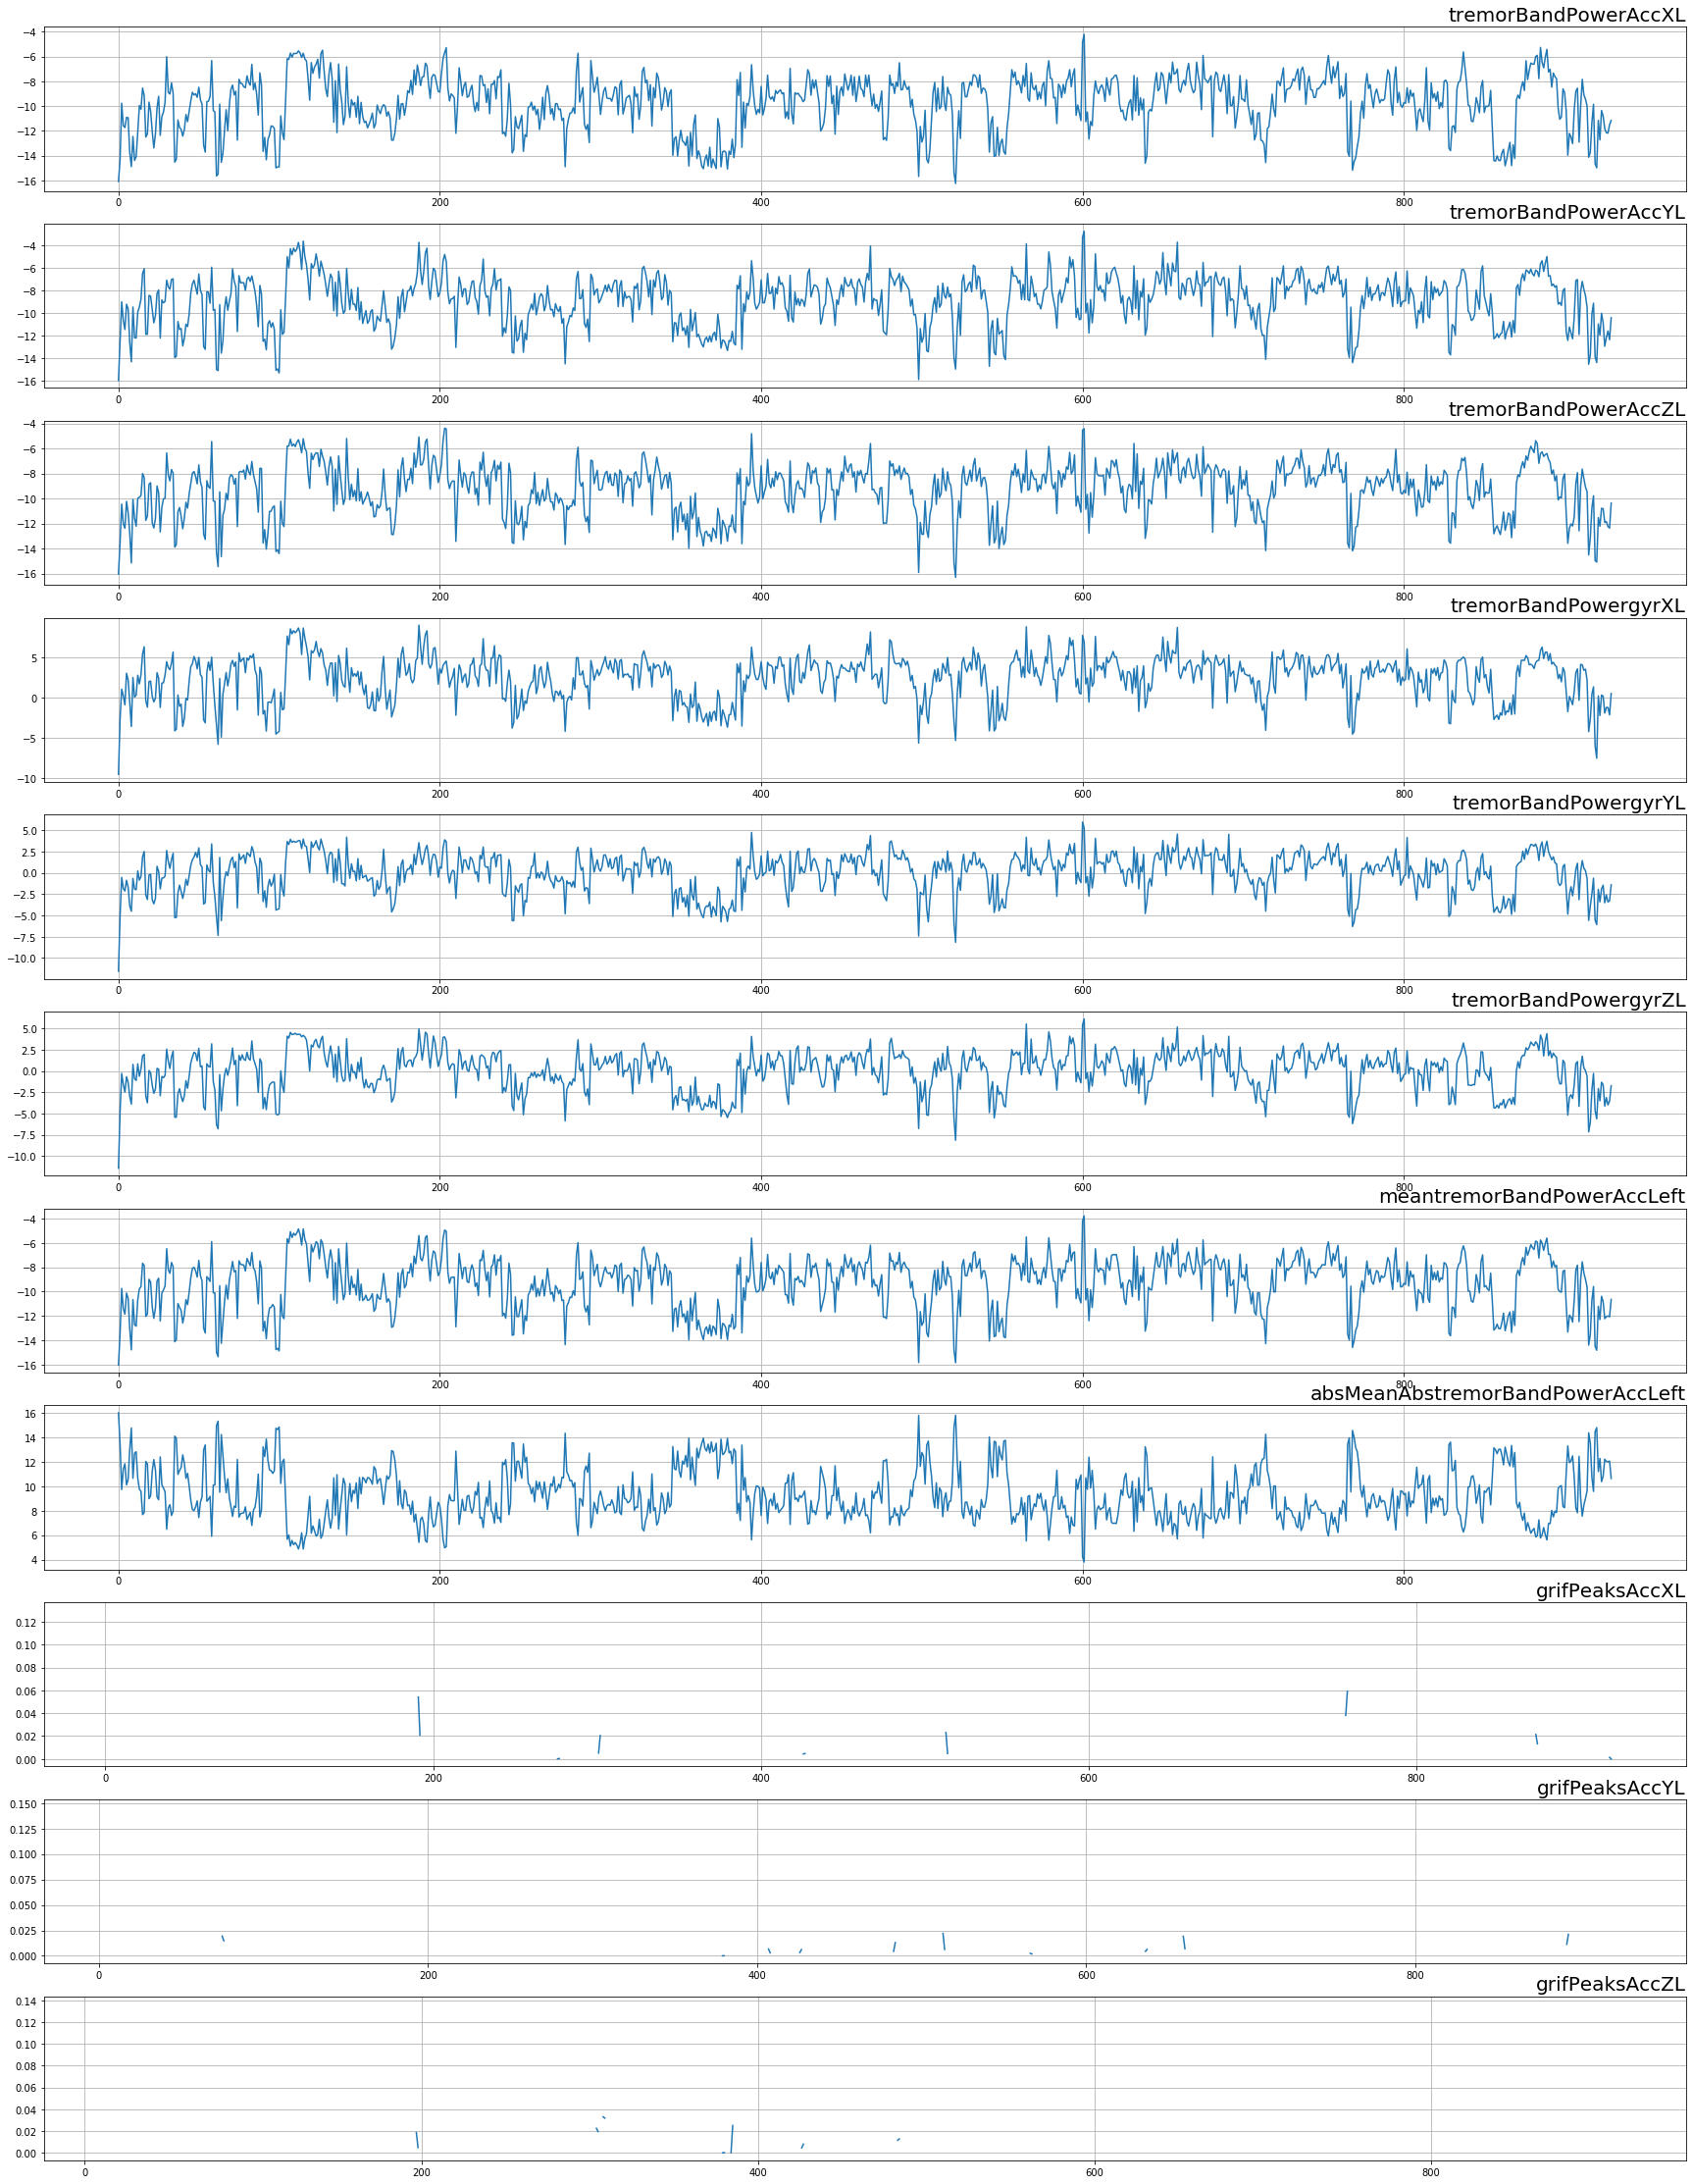

In [17]:
# test new with new labels

# items = ['slowness','stiffness','tremor','act_norpob',
#          'tremorBandPowerAccXR', 'tremorBandPowerAccYR', 'tremorBandPowerAccZR',
#  'tremorBandPowergyrXR', 'tremorBandPowergyrYR', 'tremorBandPowergyrZR',
# 'DomFreqAccXR', 'RMSAccXR', 'AmpRangeAccXR',
#  'meanAbsVecSumR', '%AbsVecImmobR', 'meanSegVelR', 'meanSegVelMovR', 
#  'angularVelocityGyrXR', 'angularRMSGyrXR', 'phiCostaGyrXR',
#  'partMoveHilGyrXR', 'rangeRotationGyrXR',
# 'powerSpecAccZR', 'accPeakAccZR',]

items = ['tremorBandPowerAccXL',
 'tremorBandPowerAccYL',
 'tremorBandPowerAccZL',
 'tremorBandPowergyrXL',
 'tremorBandPowergyrYL',
 'tremorBandPowergyrZL','meantremorBandPowerAccLeft',
 'absMeanAbstremorBandPowerAccLeft',
 'grifPeaksAccXL',
 'grifPeaksAccYL',
 'grifPeaksAccZL']

fig, axs = plt.subplots(len(items), 1, figsize=(30, 40))
for ax, item in zip(axs, items):
    ax.plot(alignedFeatures[item], )
    ax.set_title(item, loc='right', size=20)
    ax.grid(True)

plt.show()






In [18]:
### exploration of correlation of BK features

corrData = alignedFeatures.dropna(subset = ['slowness','stiffness','act_norpob',])

items = ['slowness','stiffness','tremor','act_norpob',
        'tremorBandPowerAccXR', 'tremorBandPowerAccYR', 'tremorBandPowerAccZR',
 'tremorBandPowergyrXR', 'tremorBandPowergyrYR', 'tremorBandPowergyrZR',
'DomFreqAccXR', 'RMSAccXR', 'AmpRangeAccXR',
 'meanAbsVecSumR', '%AbsVecImmobR', 'meanSegVelR', 'meanSegVelMovR', 
 'angularVelocityGyrXR', 'angularRMSGyrXR', 'phiCostaGyrXR',
 'partMoveHilGyrXR', 'rangeRotationGyrXR',
 'pulliamGyrXR','pulliamGyrXRMAP',
'powerSpecAccZR', 'accPeakAccZR',]
#'peakPowSpecAccXR'

# create empty dataframe with correct shape
heatmapR = np.zeros((len(items),len(items)))
heatmapP = np.zeros((len(items),len(items)))

# fill dataframe with R's en P's for only beep items
for x in range(len(items)):
    for y in range(len(items)):
        heatmapR[x,y],heatmapP[x,y] = spearmanr(corrData[items[x]],corrData[items[y]], )

# bonferroni correction 
heatmapP = heatmapP*(heatmapP.shape[0]*heatmapP.shape[1])

        
plt.figure(figsize=(30,30)) # use to enlarge size of figure 
plt.matshow(heatmapR, fignum=1,  cmap='seismic', vmin=-1,vmax=1, rasterized = False )      # fignum = 1  is to use the enlarged figure frame   
plt.colorbar().set_label(label='Spearman R''s',size=16,)

plt.xticks(np.arange(len(items)),items,fontsize=16,  rotation= 60)
plt.yticks(np.arange(len(items)), items,fontsize=16, rotation= 0)


# Loop over data dimensions and create text annotations.
for i in range(len(items)):
    for j in range(len(items)):
        if heatmapP[i, j] < 0.001:
            if -0.15 < heatmapR[i, j] < 0.15:
                text = plt.text(j, i, str(round(heatmapR[i, j],2))+'***', 
                            ha="center", va="center", fontsize=16, color="k")
            else:
                text = plt.text(j, i, str(round(heatmapR[i, j],2))+'***', 
                            ha="center", va="center", fontsize=16, color="w")
        elif heatmapP[i, j] < 0.01:
            if -0.15 < heatmapR[i, j] < 0.15:
                text = plt.text(j, i, str(round(heatmapR[i, j],2))+'**', 
                            ha="center", va="center", fontsize=16, color="k")
            else:
                text = plt.text(j, i, str(round(heatmapR[i, j],2))+'**', 
                            ha="center", va="center", fontsize=16, color="w")
        elif heatmapP[i, j] < 0.05:
            if -0.15 < heatmapR[i, j] < 0.15:
                text = plt.text(j, i, str(round(heatmapR[i, j],2))+'*', 
                            ha="center", va="center", fontsize=16, color="k")
            else:
                text = plt.text(j, i, str(round(heatmapR[i, j],2))+'*', 
                            ha="center", va="center", fontsize=16, color="w")
        else:
            if -0.15 < heatmapR[i, j] < 0.15:
                text = plt.text(j, i, str(round(heatmapR[i, j],2)), 
                            ha="center", va="center", fontsize=16, color="k")
            else:
                text = plt.text(j, i, str(round(heatmapR[i, j],2)), 
                            ha="center", va="center", fontsize=16, color="w")

            
plt.title("Exploring BK features v0, n=1")
plt.rcParams["axes.grid"] = False
#plt.savefig('BK_features_v0.png', format='png', dpi=300)
plt.show()  


KeyError: 'pulliamGyrXR'

analyzing issues
* how to deal with segments without movement; filter from analysis?
* or exclude only some features, 'longer period' features can stay in? e.g. percentage

* analyse three axis together, or separate scores per axis?
* explore left vs. right difference; explore correlation L/R vs. chest
movement over time?
